<a href="https://colab.research.google.com/github/robin-ochieng/Clustering-Models----Machine-Learning/blob/main/Renewals_XGBoost_Vehicle_sales_Q4_202_Predictions_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Data preprocessing


In [ ]:
#import/load the data
sales_data = pd.read_excel('/content/Renewals Data 2022 - 2023.xlsx',  index_col='Date', parse_dates = True)

In [ ]:
sales_data

,Sales
Date,
2022-01-02,42153.0
2022-01-05,2050.0
2022-01-05,38714.0
2022-01-05,7574.0
2022-01-05,5063.0
...,...
2023-12-30,15737.0
2023-12-30,10000.0
2023-12-30,13472.0


In [ ]:
renewal_business_sales = sales_data

In [ ]:
renewal_business_sales

,Sales
Date,
2022-01-02,42153.0
2022-01-05,2050.0
2022-01-05,38714.0
2022-01-05,7574.0
2022-01-05,5063.0
...,...
2023-12-30,15737.0
2023-12-30,10000.0
2023-12-30,13472.0


In [ ]:
renewal_business_sales = renewal_business_sales.resample('D').sum()

In [ ]:
renewal_business_sales

,Sales
Date,
2022-01-02,42153.0
2022-01-03,0.0
2022-01-04,0.0
2022-01-05,53401.0
2022-01-06,0.0
...,...
2023-12-27,88005.0
2023-12-28,7574.0
2023-12-29,103002.0


In [ ]:
vehicle_sales =  renewal_business_sales[renewal_business_sales != 0]
print(vehicle_sales)

               Sales
Date                
2022-01-02   42153.0
2022-01-03       NaN
2022-01-04       NaN
2022-01-05   53401.0
2022-01-06       NaN
...              ...
2023-12-27   88005.0
2023-12-28    7574.0
2023-12-29  103002.0
2023-12-30   89474.0
2023-12-31    5063.0

[729 rows x 1 columns]


In [ ]:
vehicle_sales = vehicle_sales.dropna(subset=['Sales'])
print(vehicle_sales)

               Sales
Date                
2022-01-02   42153.0
2022-01-05   53401.0
2022-01-07   64785.0
2022-01-08    7574.0
2022-01-10   83162.0
...              ...
2023-12-27   88005.0
2023-12-28    7574.0
2023-12-29  103002.0
2023-12-30   89474.0
2023-12-31    5063.0

[554 rows x 1 columns]


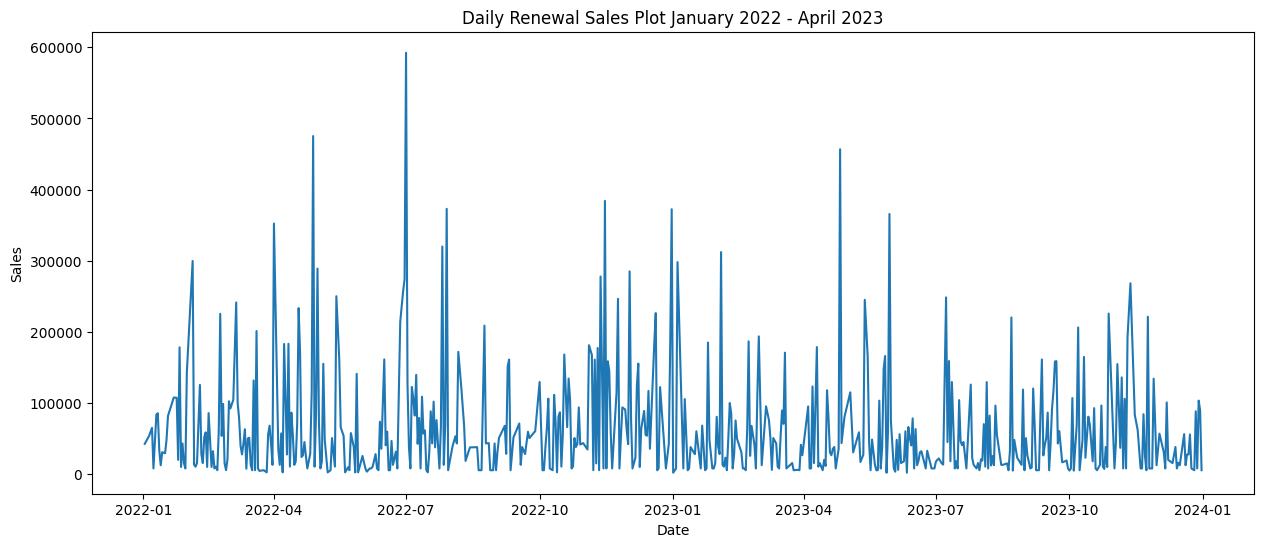

In [ ]:
# Plot the sales data to visualize the trend and seasonality
plt.figure(figsize=(15,6))
plt.plot(vehicle_sales['Sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Renewal Sales Plot January 2022 - April 2023')
plt.show()

In [ ]:
vehicle_sales

,Sales
Date,
2022-01-02,42153.0
2022-01-05,53401.0
2022-01-07,64785.0
2022-01-08,7574.0
2022-01-10,83162.0
...,...
2023-12-27,88005.0
2023-12-28,7574.0
2023-12-29,103002.0


In [ ]:
# Adding time-based features to the data
vehicle_sales['year'] = vehicle_sales.index.year
vehicle_sales['month'] = vehicle_sales.index.month
vehicle_sales['day'] = vehicle_sales.index.day
vehicle_sales['weekday'] = vehicle_sales.index.weekday
vehicle_sales['week'] = vehicle_sales.index.week
vehicle_sales['quarter'] = vehicle_sales.index.quarter
vehicle_sales['is_weekend'] = np.where(vehicle_sales['weekday'].isin([5, 6]), 1, 0)

<ipython-input-12-15fd1039e348>:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  vehicle_sales['week'] = vehicle_sales.index.week


In [ ]:
vehicle_sales

,Sales,year,month,day,weekday,week,quarter,is_weekend
Date,,,,,,,,
2022-01-02,42153.0,2022,1,2,6,52,1,1
2022-01-05,53401.0,2022,1,5,2,1,1,0
2022-01-07,64785.0,2022,1,7,4,1,1,0
2022-01-08,7574.0,2022,1,8,5,1,1,1
2022-01-10,83162.0,2022,1,10,0,2,1,0
...,...,...,...,...,...,...,...,...
2023-12-27,88005.0,2023,12,27,2,52,4,0
2023-12-28,7574.0,2023,12,28,3,52,4,0
2023-12-29,103002.0,2023,12,29,4,52,4,0


## Feature Engineering


In [ ]:
#Feature Engineering
# Creating lag features
for i in range(1, 32):
    vehicle_sales[f'sales_lag_{i}'] = vehicle_sales['Sales'].shift(i)
    vehicle_sales[f'sales_roll_mean_{i}'] = vehicle_sales['Sales'].rolling(i).mean()

In [ ]:
# Removing rows with missing values
vehicle_sales.dropna(inplace=True)

In [ ]:
vehicle_sales

,Sales,year,month,day,weekday,week,quarter,is_weekend,sales_lag_1,sales_roll_mean_1,...,sales_lag_27,sales_roll_mean_27,sales_lag_28,sales_roll_mean_28,sales_lag_29,sales_roll_mean_29,sales_lag_30,sales_roll_mean_30,sales_lag_31,sales_roll_mean_31
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-15,85423.0,2022,2,15,1,7,1,0,9637.0,85423.0,...,83162.0,61454.111111,7574.0,62229.392857,64785.0,60344.724138,53401.0,60492.733333,42153.00,60263.967742
2022-02-17,9637.0,2022,2,17,3,7,1,0,85423.0,9637.0,...,85253.0,58653.518519,83162.0,59603.500000,7574.0,60415.862069,64785.0,58654.466667,53401.00,58852.225806
2022-02-18,31952.0,2022,2,18,4,7,1,0,9637.0,31952.0,...,33230.0,58606.185185,85253.0,57699.892857,83162.0,58650.000000,7574.0,59467.066667,64785.00,57793.096774
2022-02-19,7574.0,2022,2,19,5,7,1,1,31952.0,7574.0,...,12050.0,58440.407407,33230.0,56783.607143,85253.0,55971.413793,83162.0,56947.466667,7574.00,57793.096774
2022-02-20,10126.0,2022,2,20,6,7,1,1,7574.0,10126.0,...,30411.0,57689.111111,12050.0,56714.892857,33230.0,55174.724138,85253.0,54443.233333,83162.00,55437.096774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,88005.0,2023,12,27,2,52,4,0,5063.0,88005.0,...,7574.0,42535.538148,7574.0,41286.911786,61421.0,40124.397586,82911.5,40834.284333,268075.94,42191.613871
2023-12-28,7574.0,2023,12,28,3,52,4,0,88005.0,7574.0,...,83916.0,39708.056667,7574.0,41286.911786,7574.0,40124.397586,61421.0,39039.384333,82911.50,39761.371935
2023-12-29,103002.0,2023,12,29,4,52,4,0,7574.0,103002.0,...,25063.0,42594.686296,83916.0,41968.554643,7574.0,43415.018276,7574.0,42220.317667,61421.00,41102.694516


In [ ]:
# Specifying the features and target variable
X = vehicle_sales.drop('Sales', axis=1)
y = vehicle_sales['Sales']

In [ ]:
# Splitting the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Training the Model

In [ ]:
# Hyperparameter tuning
params = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 500, 1000]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)
grid = GridSearchCV(xgb_model, params, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

# Fitting the model to the training data with the optimal hyperparameters
xgb_model = grid.best_estimator_
xgb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculating the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print('Root mean squared error:', rmse)

MAE: 743.1801525297619
MSE: 2591168.5307551236
Root mean squared error: 1609.71069784453


In [ ]:
from sklearn.metrics import r2_score

# Calculating R^2 (coefficient of determination)
r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

R^2: 0.9992789910394101


In [ ]:
#Validating the model using cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", np.mean(scores))

Cross-validation scores: [0.99608098 0.96130074 0.99669649 0.9896951  0.99936647]
Average cross-validation score: 0.9886279577480555


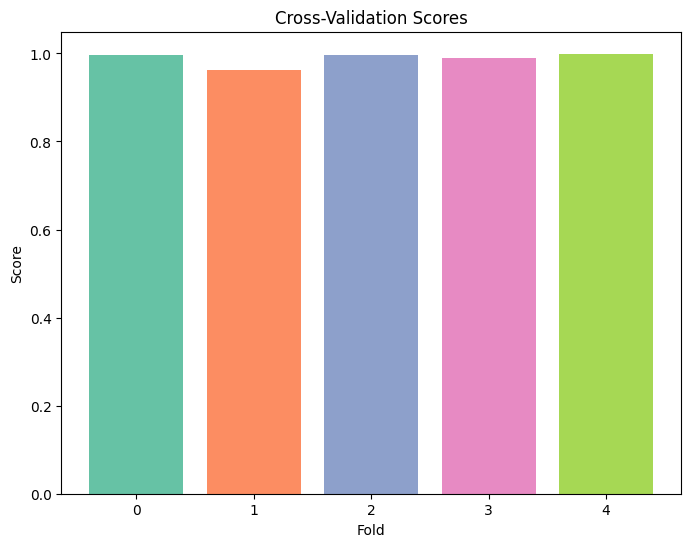

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette
palette = sns.color_palette("Set2")

plt.figure(figsize=(8, 6))
plt.bar(range(len(scores)), scores, color=palette)

plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cross-Validation Scores')
plt.show()


## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.
This plot can help you identify which input variables are the most important in predicting the target variable.
We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

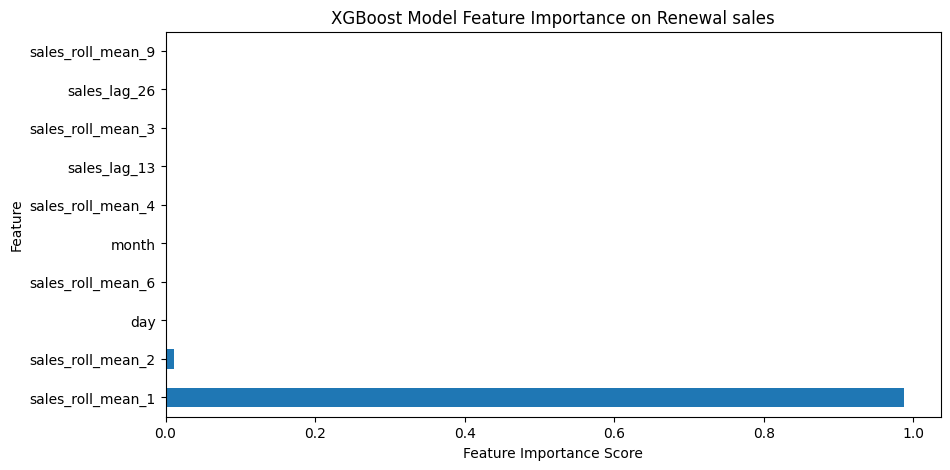

In [ ]:
plt.figure(figsize=(10, 5))
feat_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('XGBoost Model Feature Importance on Renewal sales')
plt.show()

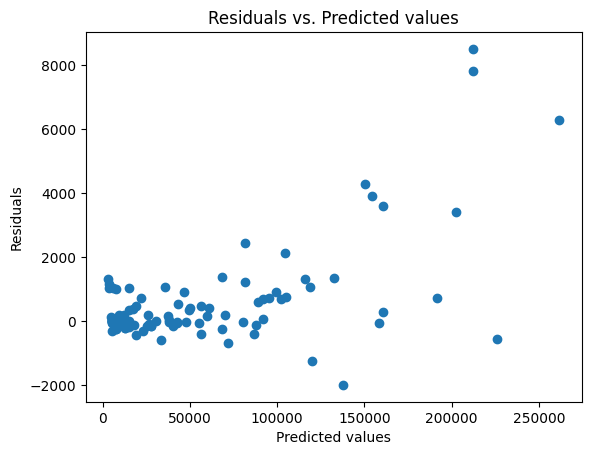

In [ ]:
#Checking for any residual patterns
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted values")
plt.show()

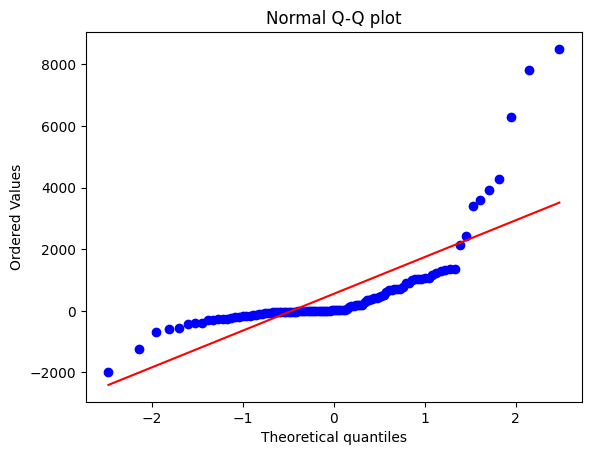

In [ ]:
#Checking the normality of the residuals
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [ ]:
#Checking for heteroscedasticity using the Breusch-Pagan test
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuals, X_test)
print("Breusch-Pagan test p-value:", bp_test[1])

Breusch-Pagan test p-value: 0.5425494934193256


In [ ]:
#Checking for autocorrelation using the Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
dw_test = durbin_watson(residuals)
print("Durbin-Watson test statistic:", dw_test)


Durbin-Watson test statistic: 1.7813978101373822


#### This Plot the shows the actual vs. predicted sales: This plots the actual and predicted sales data to visually compare the performance of the model.

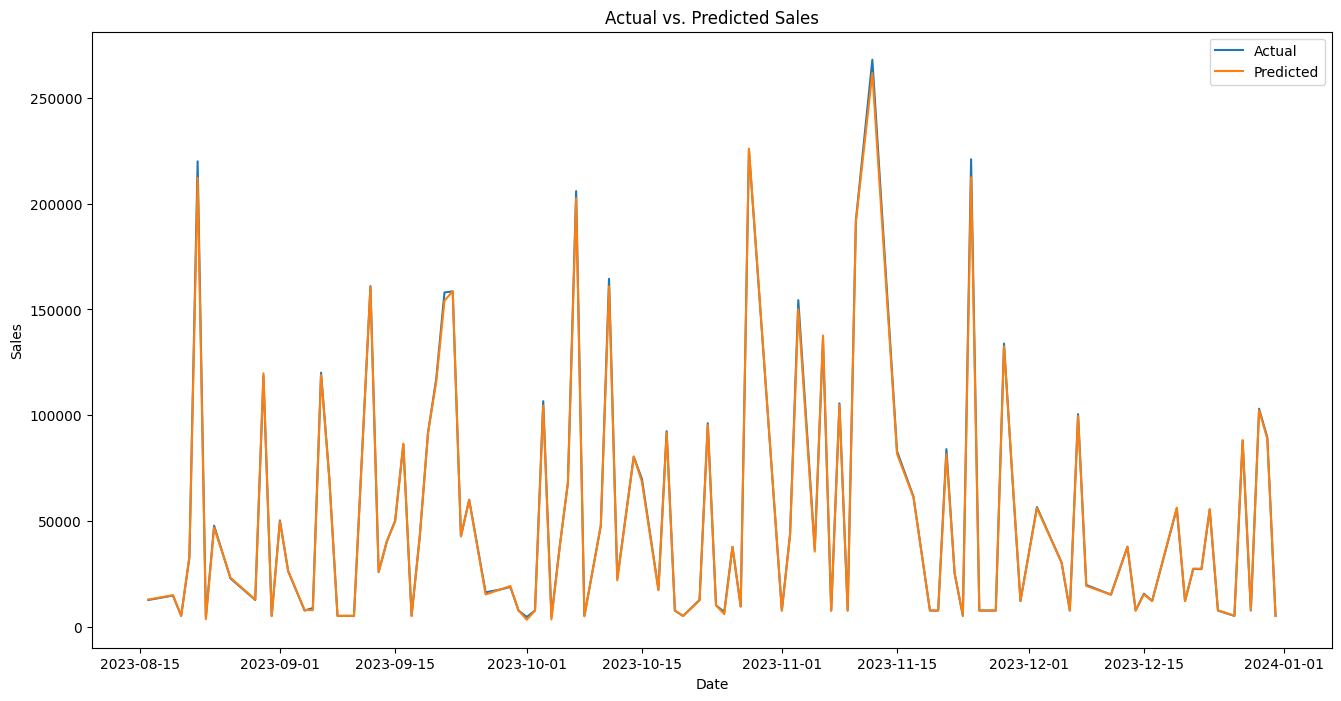

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales')
plt.legend()
plt.show()

In [ ]:
df_pred = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_pred.tail(10)

,y_test,y_pred
Date,,
2023-12-21,27242.0,27390.472656
2023-12-22,27204.0,27365.632812
2023-12-23,55400.0,55444.441406
2023-12-24,7574.0,7718.169434
2023-12-26,5063.0,5112.068359
2023-12-27,88005.0,88118.367188
2023-12-28,7574.0,7824.857422
2023-12-29,103002.0,102318.828125
2023-12-30,89474.0,88862.656250


In [ ]:
#Creating a DataFrame with the time-based features for the future dates
future_dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')

In [ ]:
len(future_dates)

366

In [ ]:
#Creating a DataFrame with the time-based features for the future dates:
future_data = pd.DataFrame({
    'year': future_dates.year,
    'month': future_dates.month,
    'day': future_dates.day,
    'weekday': future_dates.weekday,
    'week': future_dates.week,
    'quarter': future_dates.quarter,
    'is_weekend': np.where(future_dates.weekday.isin([5,6]), 1, 0)
    })


<ipython-input-32-158b649579cd>:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  'week': future_dates.week,


In [ ]:
# Adding lag features to the future data using the last 31 days of sales from the original data
for i in range(1, 32):
    future_data[f'sales_lag_{i}'] = vehicle_sales['Sales'].shift(i).values[-366:]
    future_data[f'sales_roll_mean_{i}'] = vehicle_sales['Sales'].rolling(i).mean().values[-366:]

In [ ]:
#Use the trained XGBoost model to make predictions on the future data
future_predictions = xgb_model.predict(future_data)

In [ ]:
#Create a DataFrame with the date and predicted sales for the next three months:
forecast = pd.DataFrame({
    'Date': future_dates,
    'Sales': future_predictions
})

In [ ]:
forecast.to_excel('forecasts_Renewals.xlsx', index=False)

In [ ]:
forecast.head(20)

,Date,Sales
0,2024-01-01,31220.394531
1,2024-01-02,50472.257812
2,2024-01-03,67544.421875
3,2024-01-04,28064.337891
4,2024-01-05,151041.421875
5,2024-01-06,160759.796875
6,2024-01-07,5060.198730
7,2024-01-08,51223.203125
8,2024-01-09,70557.679688
9,2024-01-10,12639.078125


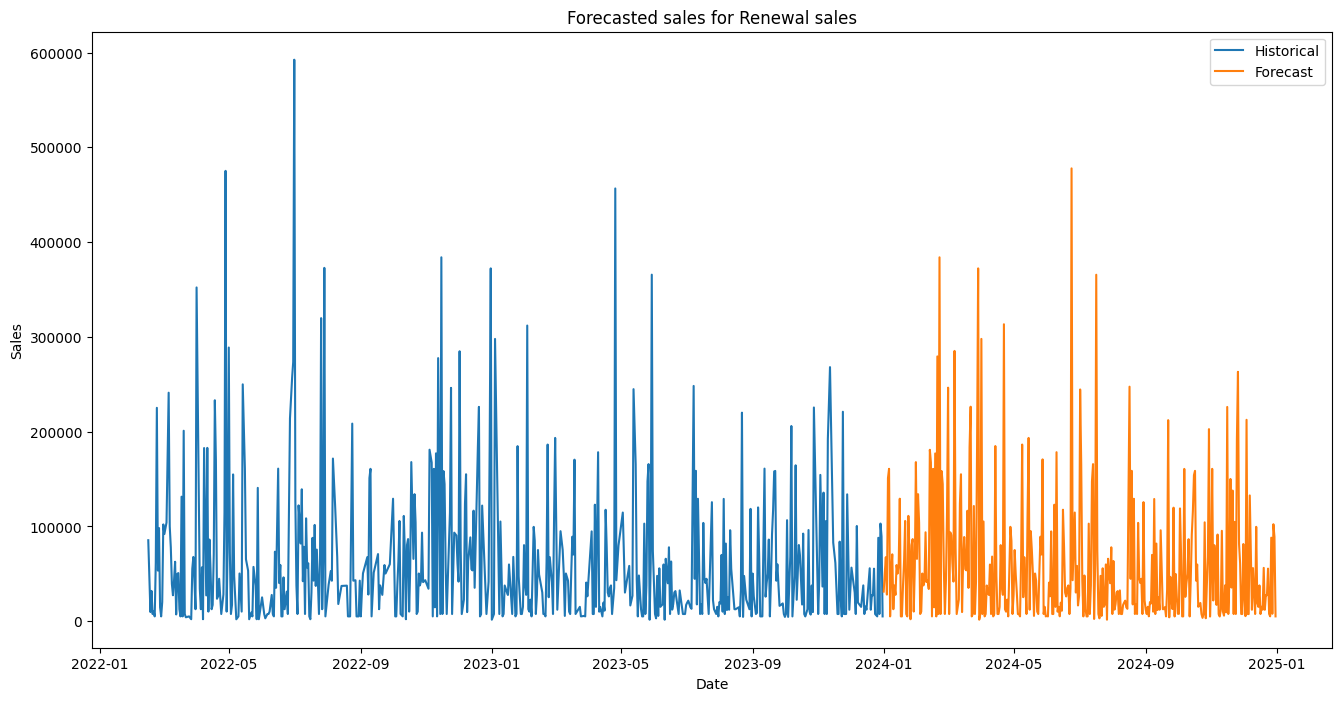

In [ ]:
#Visualize the forecasted sales:
plt.figure(figsize=(16, 8))
plt.plot(vehicle_sales.index, vehicle_sales['Sales'], label='Historical')
plt.plot(forecast['Date'], forecast['Sales'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecasted sales for Renewal sales')
plt.legend()
plt.show()

## Analysing the Predicted Sales Data

In [ ]:
forecast['Date'] = pd.to_datetime(forecast['Date'])
forecast['Day'] = forecast['Date'].dt.day
forecast['Week'] = forecast['Date'].dt.week
forecast['Month'] = forecast['Date'].dt.month
forecast['Quarter'] = forecast['Date'].dt.quarter


daily_trends = forecast.groupby('Day')['Sales'].mean()
weekly_trends = forecast.groupby('Week')['Sales'].mean()
monthly_trends = forecast.groupby('Month')['Sales'].mean()
quarterly_trends = forecast.groupby('Quarter')['Sales'].mean()

<ipython-input-39-f79ae8997575>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  forecast['Week'] = forecast['Date'].dt.week


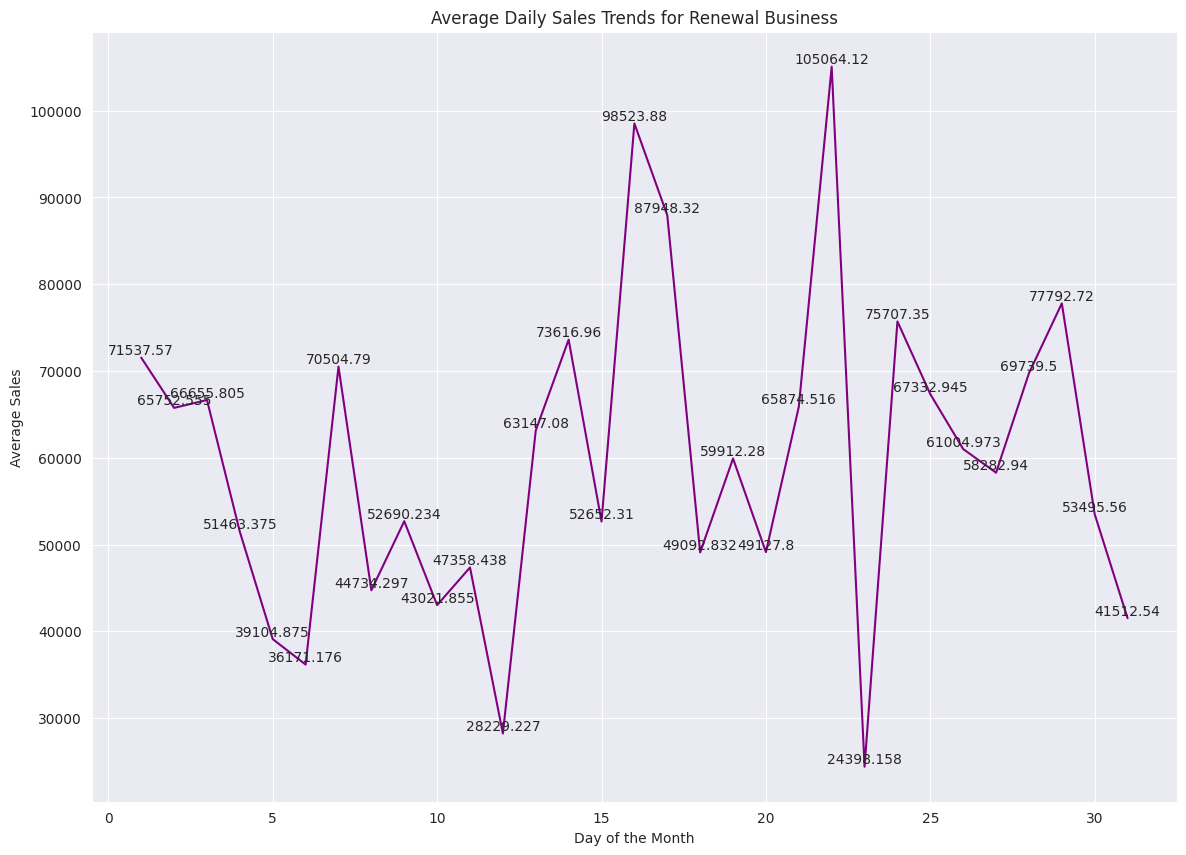

In [ ]:
plt.figure(figsize=(14, 10))
sns.set_style("darkgrid")
sns.color_palette("viridis")
plt.plot(daily_trends.index, daily_trends.values, color='purple')
plt.xlabel('Day of the Month')
plt.ylabel('Average Sales')
plt.title('Average Daily Sales Trends for Renewal Business')
# Add data labels
for x, y in zip(daily_trends.index, daily_trends.values):
    plt.text(x, y, str(y), ha='center', va='bottom')
plt.show()


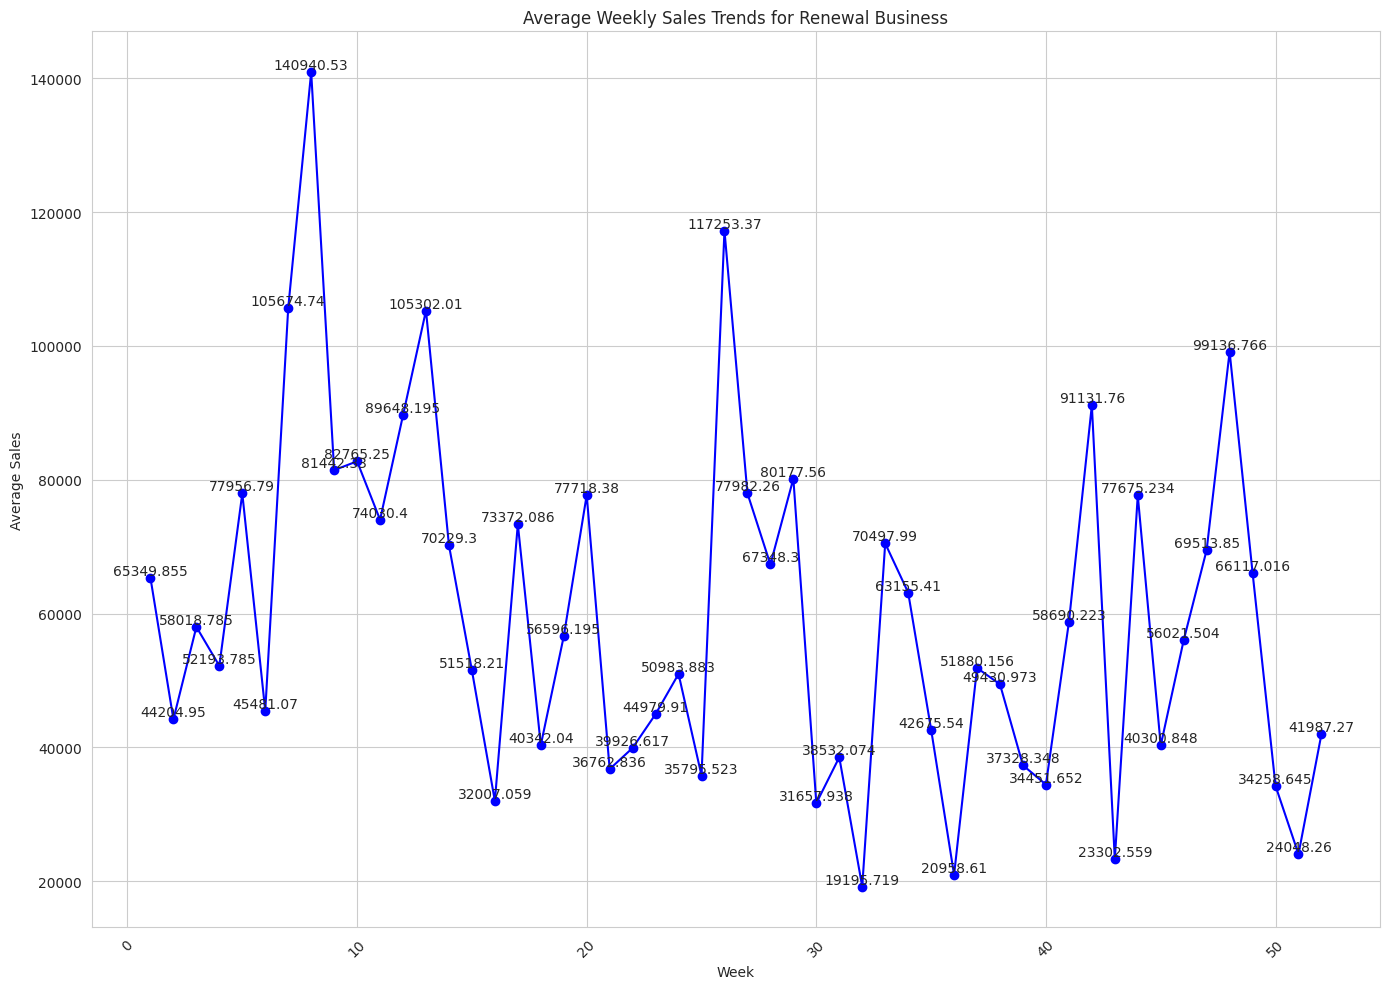

In [ ]:
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")
plt.plot(weekly_trends.index, weekly_trends.values, marker='o', linestyle='-', color='b')
plt.xlabel('Week')
plt.ylabel('Average Sales')
plt.title('Average Weekly Sales Trends for Renewal Business')
plt.xticks(rotation=45)
# Add data labels
for x, y in zip(weekly_trends.index, weekly_trends.values):
    plt.text(x, y, str(y), ha='center', va='bottom')
plt.tight_layout()
plt.show()

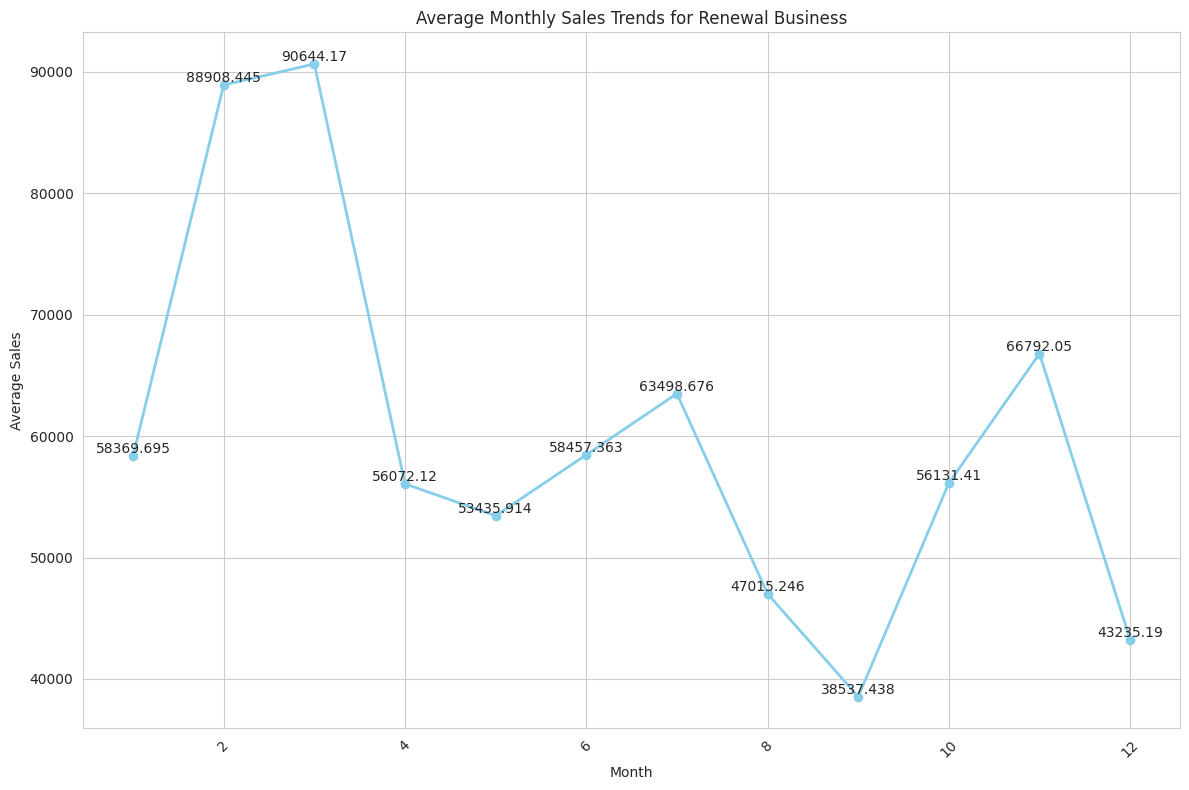

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
plt.plot(monthly_trends.index, monthly_trends.values, color='skyblue', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Average Monthly Sales Trends for Renewal Business')
#Add data labels
for x, y in zip(monthly_trends.index, monthly_trends.values):
    plt.text(x, y, str(y), ha='center', va='bottom')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


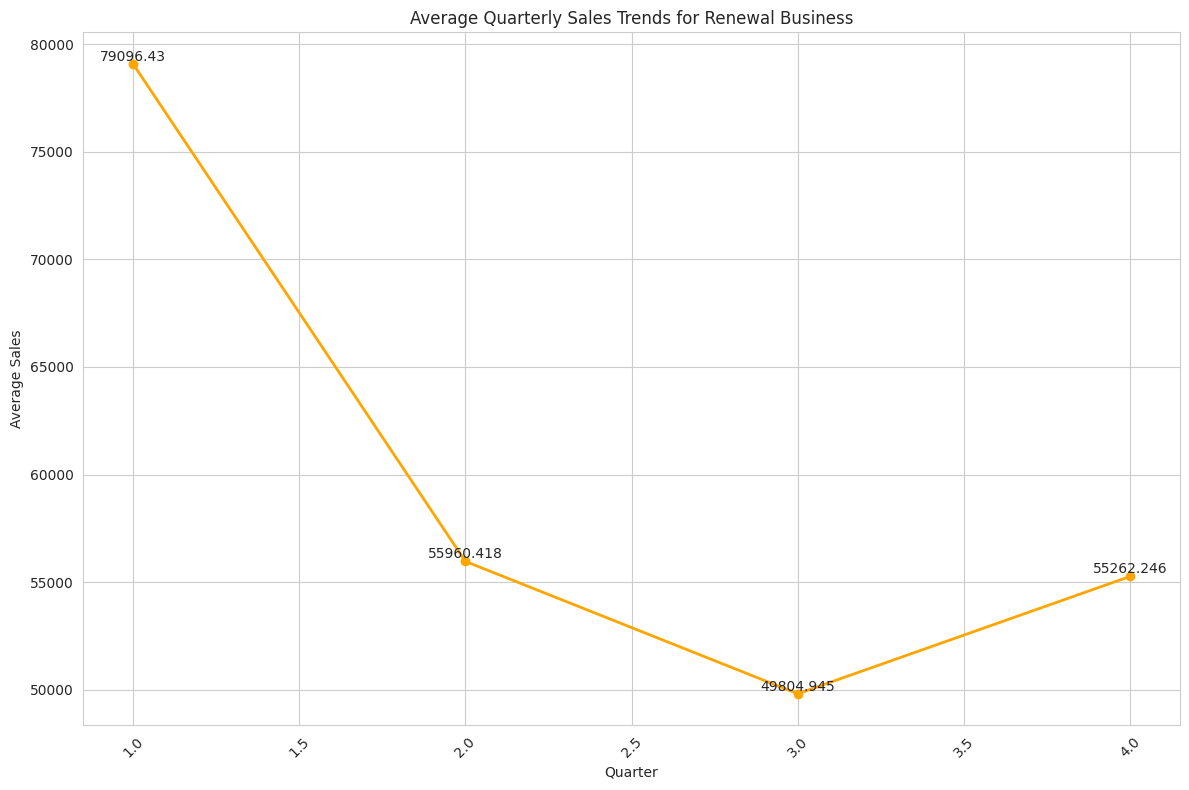

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
plt.plot(quarterly_trends.index, quarterly_trends.values, color='orange', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Quarter')
plt.ylabel('Average Sales')
plt.title('Average Quarterly Sales Trends for Renewal Business')
# Add data labels
for x, y in zip(quarterly_trends.index, quarterly_trends.values):
    plt.text(x, y, str(y), ha='center', va='bottom')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

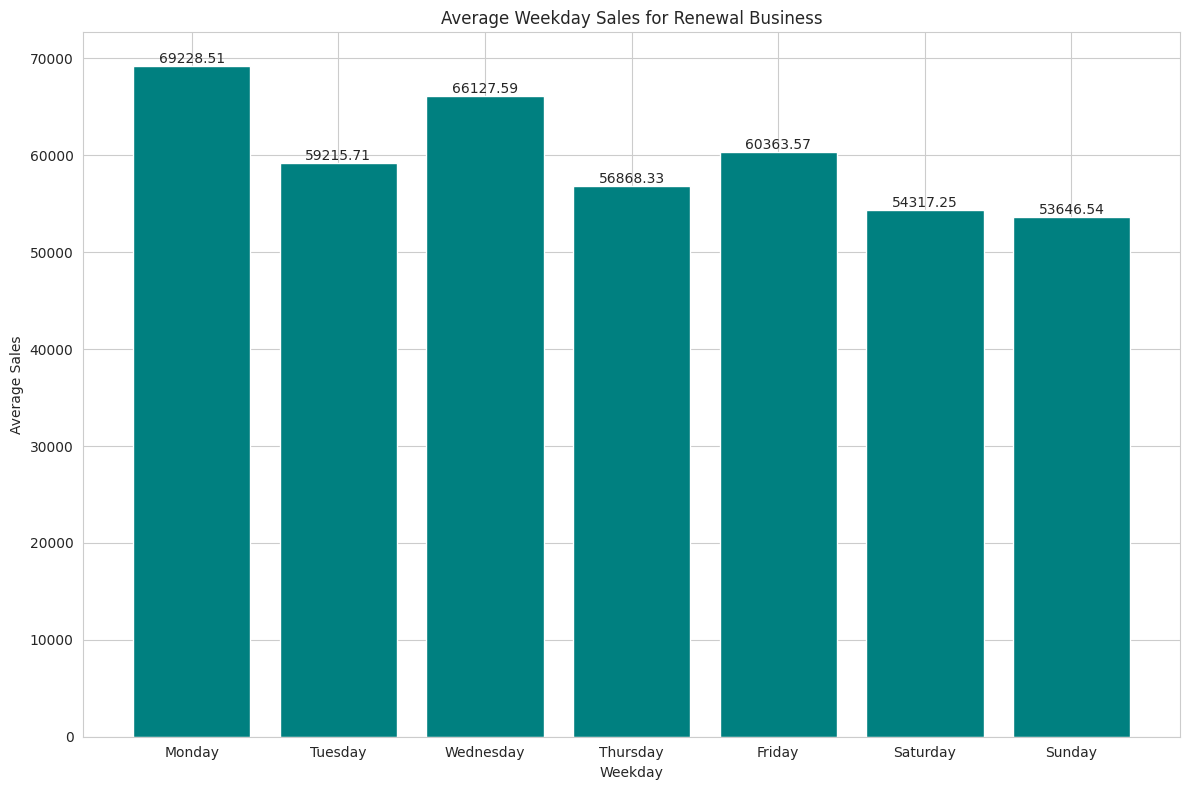

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = forecast.groupby(forecast['Date'].dt.weekday)['Sales'].mean()
plt.bar(weekday_labels, weekday_sales, color='teal')
plt.xlabel('Weekday')
plt.ylabel('Average Sales')
plt.title('Average Weekday Sales for Renewal Business')
# Add data labels
for x, y in zip(weekday_labels, weekday_sales):
    plt.text(x, y, str(round(y, 2)), ha='center', va='bottom')
plt.tight_layout()
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (9,) and arg 1 with shape (12,).

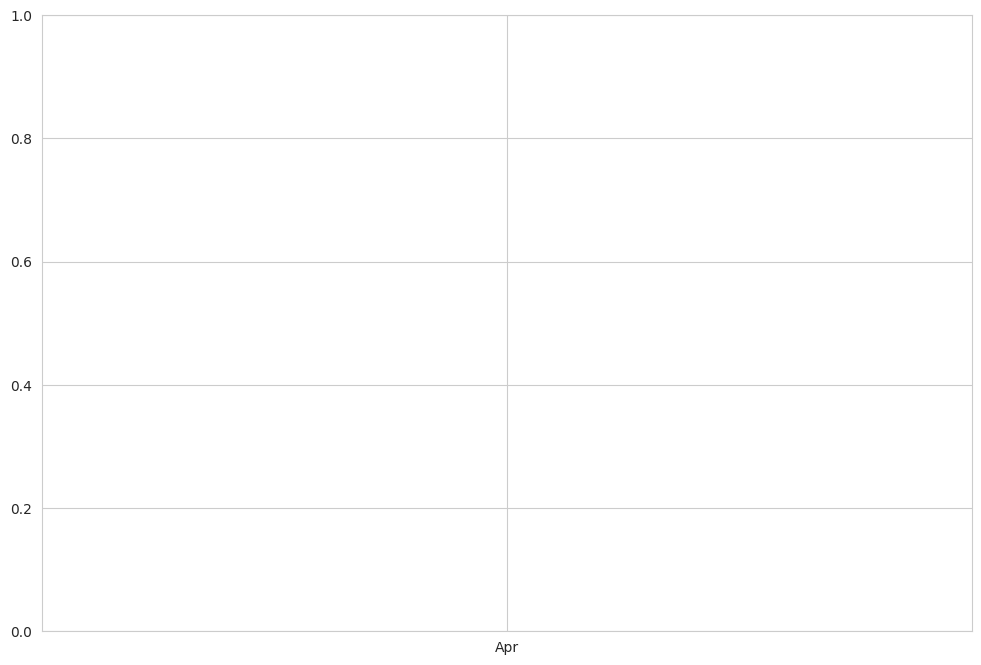

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
month_labels = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sales = forecast.groupby('Month')['Sales'].mean()
plt.bar(month_labels, monthly_sales, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Monthly Sales for Renewal Business')
# Add data labels
for x, y in zip(month_labels, monthly_sales):
    plt.text(x, y, str(round(y, 2)), ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style("darkgrid")
plt.plot(forecast['Date'], forecast['Sales'], color='purple')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.title('Predicted Sales Over Time for Renewal Business')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import calendar
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
monthly_sales = forecast.groupby(forecast['Date'].dt.strftime('%Y-%m'))['Sales'].sum()
month_labels = [calendar.month_name[int(month[-2:])] for month in monthly_sales.index]
plt.bar(month_labels, monthly_sales, color='teal')
plt.xlabel('Month')
plt.ylabel('Predicted Sales')
plt.title('Monthly Predicted Sales for Renewal Business')
# Add data labels
for x, y in zip(month_labels, monthly_sales):
    plt.text(x, y, str(round(y, 2)), ha='center', va='bottom')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sales_data = forecast['Sales']
plt.hist(sales_data, bins=20, color='teal', alpha=0.7)
plt.xlabel('Predicted Sales')
plt.ylabel('Frequency')
plt.title('Predicted Sales Distribution for Renewal Business')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate average sales for each day of the week
forecast['DayOfWeek'] = forecast['Date'].dt.day_name()
average_sales_by_day = forecast.groupby('DayOfWeek')['Sales'].sum()
# Define the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Reorder the average_sales_by_day series based on day_order
average_sales_by_day = average_sales_by_day.reindex(day_order)
# Create the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=average_sales_by_day.index, y=average_sales_by_day, palette='viridis')
plt.xlabel('Day of the Week')
plt.ylabel('Sum of Predicted Sales')
plt.title('Sum of Predicted Sales by Day of the Week for Renewal Business')
# Add values to the bars
for i, value in enumerate(average_sales_by_day):
    plt.text(i, value, str(value), ha='center', va='bottom', fontweight='bold')
plt.show()